# YoloV8

为了更好地理解视觉语言模型（VLM）在处理复杂视觉任务时的独特优势，我们首先回顾并实践一种经典且高效的目标检测框架——YOLOv8。通过亲手操作YOLOv8，我们将能更深刻地体会到其在速度和精度上的强大之处，同时也能清晰地认识到它在理解自然语言指令方面的局限性。这为我们后续深入探索为何需要ViT等更先进架构的VLM奠定了坚实的基础。我们将构建一个完整的、独立的流程，从加载 `TextVQA` 数据集开始，将其转换为 YOLOv8 所需的格式，并最终进行模型的微调和验证。

## 核心差异：VLM vs. YOLOv8

在开始之前，理解两种方法的核心区别至关重要：

| 特性         | Qwen2.5-VL (VLM)                                       | YOLOv8 (传统检测器)                                          |
| ------------ | ------------------------------------------------------ | ------------------------------------------------------------ |
| **任务定义** | 将检测视为**语言生成**任务，输出包含坐标的文本字符串。 | 将检测视为**回归与分类**任务，直接预测边界框坐标和类别概率。 |
| **数据格式** | 对话式的 JSONL 文件，包含图像路径和图文指令。          | 特定格式的 `.txt` 标签文件，每行代表一个物体，包含类别ID和归一化坐标。 |
| **模型结构** | 视觉编码器 + 大型语言模型。                            | 专为速度和精度优化的 CNN/Transformer 骨干网络 + 检测头。     |
| **灵活性**   | 极高，能理解复杂的自然语言指令。                       | 专注于预定义的类别，对指令的理解能力有限。                   |
| **效率**     | 推理和训练开销较大。                                   | 训练和推理速度极快，易于部署。                               |

## 步骤 1：环境与项目配置

首先，我们需要一个项目目录来存放所有的数据和代码，并安装 YOLOv8 的官方库 ultralytics。

### 安装依赖库

In [4]:
# 建议在一个干净的环境中安装
!pip install -q ultralytics datasets tqdm pillow pyyaml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 849.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.3 MB/s eta 0:00:00


### 挂载云端硬盘并设置工作目录

这是推荐的第一步，它能确保我们所有的文件都保存在一个固定的位置，并且后续可以使用相对路径。

In [1]:
import os
from google.colab import drive

# 挂载 Google Drive
print("正在挂载 Google Drive...")
drive.mount('/content/drive')
print("Google Drive 挂载成功！")

# 定义并创建项目根目录
# 我们将把这个目录作为我们的工作空间
BASE_DIR = "/content/drive/MyDrive/YOLOv8_Finetune_Project"
if not os.path.exists(BASE_DIR):
    os.makedirs(BASE_DIR)
    print(f"项目根目录已创建: {BASE_DIR}")
else:
    print(f"项目根目录已存在: {BASE_DIR}")

# 切换当前工作目录到项目根目录
# 注意：在Jupyter/Colab中，需要使用 %cd 魔法命令
%cd {BASE_DIR}
print(f"当前工作目录已切换至: {os.getcwd()}")

正在挂载 Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive 挂载成功！
项目根目录已存在: /content/drive/MyDrive/YOLOv8_Finetune_Project
/content/drive/MyDrive/YOLOv8_Finetune_Project
当前工作目录已切换至: /content/drive/MyDrive/YOLOv8_Finetune_Project


### 定义项目配置变量

现在我们已经位于项目根目录 BASE_DIR 中，所有的路径都可以基于当前位置进行相对定义。

In [7]:
import yaml
import os
import json
import random
import shutil
from tqdm import tqdm
from PIL import Image
from datasets import load_dataset, load_from_disk

# --- 1. 数据集配置 ---
# DATASET_NAME = "jrzhang/TextVQA_GT_bbox"
DATASET_NAME = "detection-datasets/coco"
DATASET_SPLIT = "train"

# --- 2. 相对路径配置 ---
# 由于我们已在BASE_DIR中，可以直接使用相对路径
YOLO_DATA_DIR = "yolo_dataset"
# 新增：用于保存原始Hugging Face数据集的本地缓存路径
LOCAL_DATASET_PATH = "hf_dataset_cache"


YOLO_IMAGES_DIR = os.path.join(YOLO_DATA_DIR, "images")
YOLO_LABELS_DIR = os.path.join(YOLO_DATA_DIR, "labels")

YOLO_IMAGES_TRAIN_DIR = os.path.join(YOLO_IMAGES_DIR, "train")
YOLO_LABELS_TRAIN_DIR = os.path.join(YOLO_LABELS_DIR, "train")
YOLO_IMAGES_VAL_DIR = os.path.join(YOLO_IMAGES_DIR, "val")
YOLO_LABELS_VAL_DIR = os.path.join(YOLO_LABELS_DIR, "val")

YAML_FILE_PATH = os.path.join(YOLO_DATA_DIR, "dataset.yaml")

# 用于在Colab本地高速磁盘上进行数据转换的临时目录
TEMP_YOLO_DATA_DIR = "/content/yolo_dataset_temp"

# --- 3. 数据处理配置 ---
VAL_SPLIT_RATIO = 0.1

TARGET_CLASS = 'person' # 我们只对 'person' 这一个类别感兴趣

print("项目配置加载完毕。")
print(f"所有数据将被处理并存放到: '{os.path.abspath(YOLO_DATA_DIR)}'")

项目配置加载完毕。
所有数据将被处理并存放到: '/content/drive/MyDrive/YOLOv8_Finetune_Project/yolo_dataset'


## 步骤 2：数据下载与格式转换

这是将原始 `TextVQA` 数据适配到 YOLOv8 的核心步骤。我们将执行以下操作：

1. 创建 YOLOv8 需要的目录结构。
2. 从 Hugging Face 下载并加载数据集。
3. 从数据集中动态提取所有类别，并创建映射。
4. 将数据随机划分为训练集和验证集。
5. 编写转换函数，将每条数据（图片和标注）转换为 YOLO 格式。
6. 生成最终的 `dataset.yaml` 配置文件。





### **创建目录结构**

In [3]:
# --- 使用相对路径创建 YOLOv8 所需的完整目录结构 ---
os.makedirs(YOLO_IMAGES_TRAIN_DIR, exist_ok=True)
os.makedirs(YOLO_LABELS_TRAIN_DIR, exist_ok=True)
os.makedirs(YOLO_IMAGES_VAL_DIR, exist_ok=True)
os.makedirs(YOLO_LABELS_VAL_DIR, exist_ok=True)

print("YOLOv8 目录结构创建成功！")


YOLOv8 目录结构创建成功！


### 加载数据并创建类别映射

In [8]:
print(f"\n正在从 Hugging Face 加载数据集: {DATASET_NAME}...")
dataset = load_dataset(DATASET_NAME, split=DATASET_SPLIT)
print("数据集加载成功！")


正在从 Hugging Face 加载数据集: detection-datasets/coco...


Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/20 [00:00<?, ?it/s]

数据集加载成功！


In [9]:
# 🔥🔥🔥 修改点 3: 获取所有类别，并筛选出目标类别的数据
print("\n正在从数据集元信息中提取类别...")
all_class_names = dataset.features['objects']['category'].feature.names
try:
    target_class_id = all_class_names.index(TARGET_CLASS)
    print(f"目标类别 '{TARGET_CLASS}' 的ID为: {target_class_id}")
except ValueError:
    print(f"错误：目标类别 '{TARGET_CLASS}' 不在数据集中！")
    # 可以在这里停止执行或引发异常

print(f"\n正在筛选只包含 '{TARGET_CLASS}' 的数据...")
def contains_target_class(sample):
    return target_class_id in sample['objects']['category']

filtered_dataset = dataset.filter(contains_target_class, num_proc=os.cpu_count())
print(f"筛选完成！原始数据: {len(dataset)} 条, 筛选后数据: {len(filtered_dataset)} 条。")


正在从数据集元信息中提取类别...
目标类别 'person' 的ID为: 0

正在筛选只包含 'person' 的数据...


Filter (num_proc=2):   0%|          | 0/117266 [00:00<?, ? examples/s]

筛选完成！原始数据: 117266 条, 筛选后数据: 64115 条。


In [11]:
print("\n正在从数据集元信息中提取类别...")
# COCO数据集的类别信息存储在features中，这是最高效的获取方式
class_names = filtered_dataset.features['objects']['category'].feature.names
class_to_id = {name: i for i, name in enumerate(class_names)}
print(f"处理完成！共找到 {len(class_names)} 个独立类别。")


正在从数据集元信息中提取类别...
处理完成！共找到 80 个独立类别。


### 划分数据集并执行转换

In [ ]:
from functools import partial

def convert_sample_to_yolo(sample, index, image_dest_dir, label_dest_dir, original_target_id):
    """
    将Hugging Face COCO数据集的单个样本转换为YOLOv8格式。
    此函数现在只处理目标类别，并将其ID映射为0。
    """
    image = sample['image']
    if image.mode != 'RGB':
        image = image.convert('RGB')

    image_id = sample.get('image_id', index)
    image_filename = f"coco_{image_id}.jpg"
    image_save_path = os.path.join(image_dest_dir, image_filename)
    image.save(image_save_path)

    label_filename = os.path.splitext(image_filename)[0] + ".txt"
    label_path = os.path.join(label_dest_dir, label_filename)

    img_w, img_h = image.size

    with open(label_path, 'w', encoding='utf-8') as f:
        if not sample['objects']['bbox']:
            return {}

        num_objects = len(sample['objects']['bbox'])
        for i in range(num_objects):
            class_id = sample['objects']['category'][i]

            # 只处理目标类别的物体
            if class_id == original_target_id:
                x, y, w, h = sample['objects']['bbox'][i]

                x_center = (x + w / 2) / img_w
                y_center = (y + h / 2) / img_h
                norm_w = w / img_w
                norm_h = h / img_h

                # 写入新的类别ID，永远是0
                f.write(f"0 {x_center:.6f} {y_center:.6f} {norm_w:.6f} {norm_h:.6f}\n")
    return {}

# 划分数据集并执行转换
print("\n正在划分数据集并执行格式转换...")
shuffled_dataset = filtered_dataset.shuffle(seed=42)
split_dataset = shuffled_dataset.train_test_split(test_size=VAL_SPLIT_RATIO)
train_dataset = split_dataset['train']
val_dataset = split_dataset['test']

# 使用 fn_kwargs 向 map 函数传递额外参数，这是比 functools.partial 更稳健的方法
train_kwargs = {
    "image_dest_dir": YOLO_IMAGES_TRAIN_DIR,
    "label_dest_dir": YOLO_LABELS_TRAIN_DIR,
    "original_target_id": target_class_id
}
val_kwargs = {
    "image_dest_dir": YOLO_IMAGES_VAL_DIR,
    "label_dest_dir": YOLO_LABELS_VAL_DIR,
    "original_target_id": target_class_id
}

train_dataset.map(convert_sample_to_yolo, with_indices=True, fn_kwargs=train_kwargs, num_proc=os.cpu_count())
val_dataset.map(convert_sample_to_yolo, with_indices=True, fn_kwargs=val_kwargs, num_proc=os.cpu_count())
print("数据转换完成！")



正在划分数据集并执行格式转换...


Map (num_proc=2):   0%|          | 0/57703 [00:00<?, ? examples/s]

### 生成 dataset.yaml 配置文件

In [ ]:
# --- 创建 YAML 配置文件所需的数据结构 ---
# YOLOv8的配置文件需要一个绝对路径来定位数据集，或者一个相对于yolo命令运行位置的路径。
# 使用os.path.abspath('.')可以确保路径的鲁棒性。
yaml_data = {
    'path': os.path.abspath('.'),  # 指向当前工作目录 (即BASE_DIR)
    'train': os.path.join(YOLO_DATA_DIR, 'images', 'train'),  # 相对于path的训练集图片路径
    'val': os.path.join(YOLO_DATA_DIR, 'images', 'val'),    # 相对于path的验证集图片路径
    'nc': len(class_names),
    'names': sorted(list(class_names))
}

# --- 将数据写入 YAML 文件 ---
with open(YAML_FILE_PATH, 'w', encoding='utf-8') as f:
    yaml.dump(yaml_data, f, default_flow_style=False, sort_keys=False, allow_unicode=True)

print(f"\nYOLOv8 配置文件已成功创建于: {YAML_FILE_PATH}")
print("\n--- YAML 文件内容预览 ---")
# print(yaml.dump(yaml_data, allow_unicode=True))

In [ ]:
train_images = set(os.path.splitext(f)[0] for f in os.listdir(YOLO_IMAGES_TRAIN_DIR))
train_labels = set(os.path.splitext(f)[0] for f in os.listdir(YOLO_LABELS_TRAIN_DIR))

val_images = set(os.path.splitext(f)[0] for f in os.listdir(YOLO_IMAGES_VAL_DIR))
val_labels = set(os.path.splitext(f)[0] for f in os.listdir(YOLO_LABELS_VAL_DIR))

print(f"训练集: {len(train_images)} 张图片, {len(train_labels)} 个标签文件。")
if len(train_images) != len(train_labels):
    print("❌ 警告：训练集图片和标签数量不匹配！")
    print("仅存在于图片文件夹中的文件:", len(train_images - train_labels))
    print("仅存在于标签文件夹中的文件:", len(train_labels - train_images))


print(f"验证集: {len(val_images)} 张图片, {len(val_labels)} 个标签文件。")
if len(val_images) != len(val_labels):
    print("❌ 警告：验证集图片和标签数量不匹配！")

✅ YAML配置文件加载成功！

🔍 正在检查图片: textvqa_2049.jpg
✅ 成功在图上绘制: Class=sambuca, Bbox=[208.0, 123.0, 622.0, 532.0]


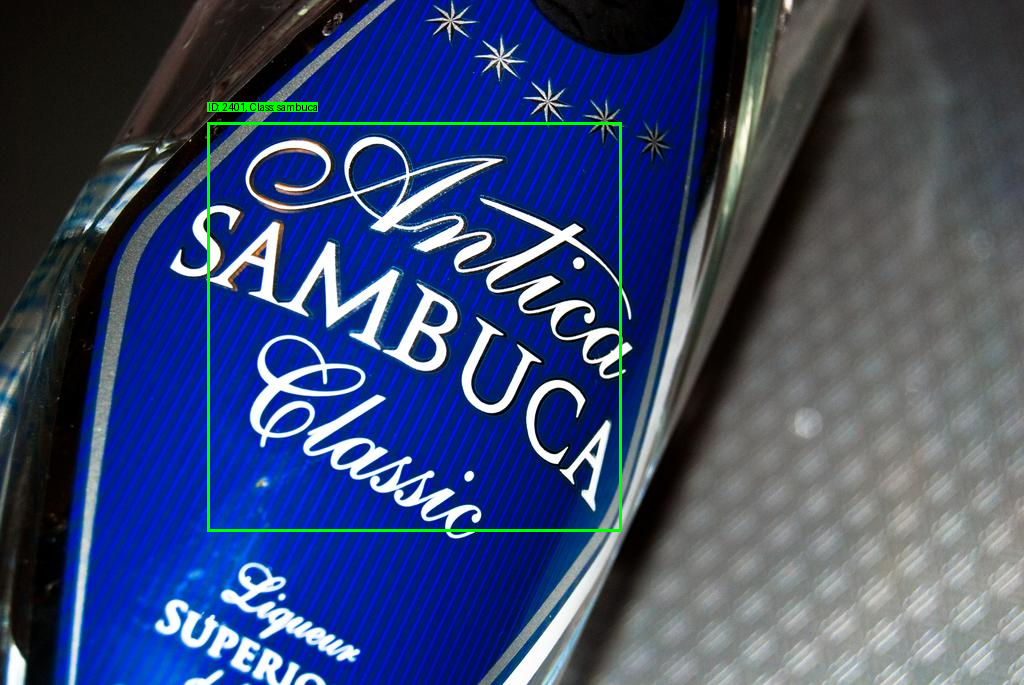


🔍 正在检查图片: textvqa_1025.jpg
✅ 成功在图上绘制: Class=23, Bbox=[244.0, 341.0, 396.0, 497.0]


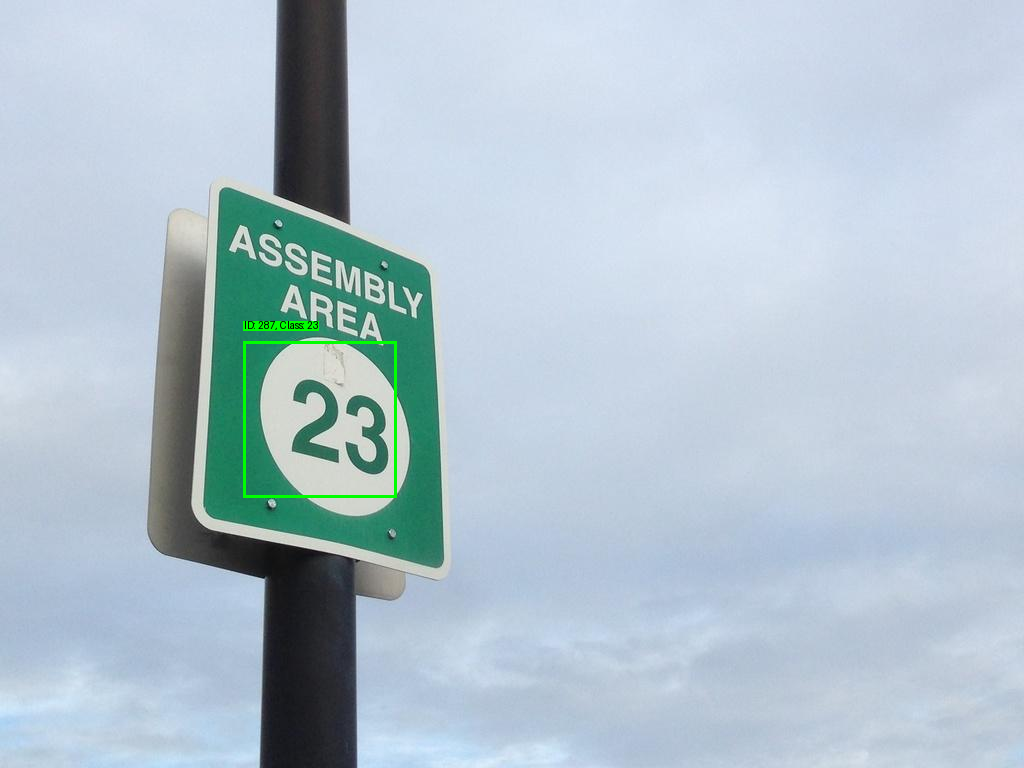


🔍 正在检查图片: textvqa_1049.jpg
✅ 成功在图上绘制: Class=ef, Bbox=[127.0, 533.0, 205.0, 567.0]


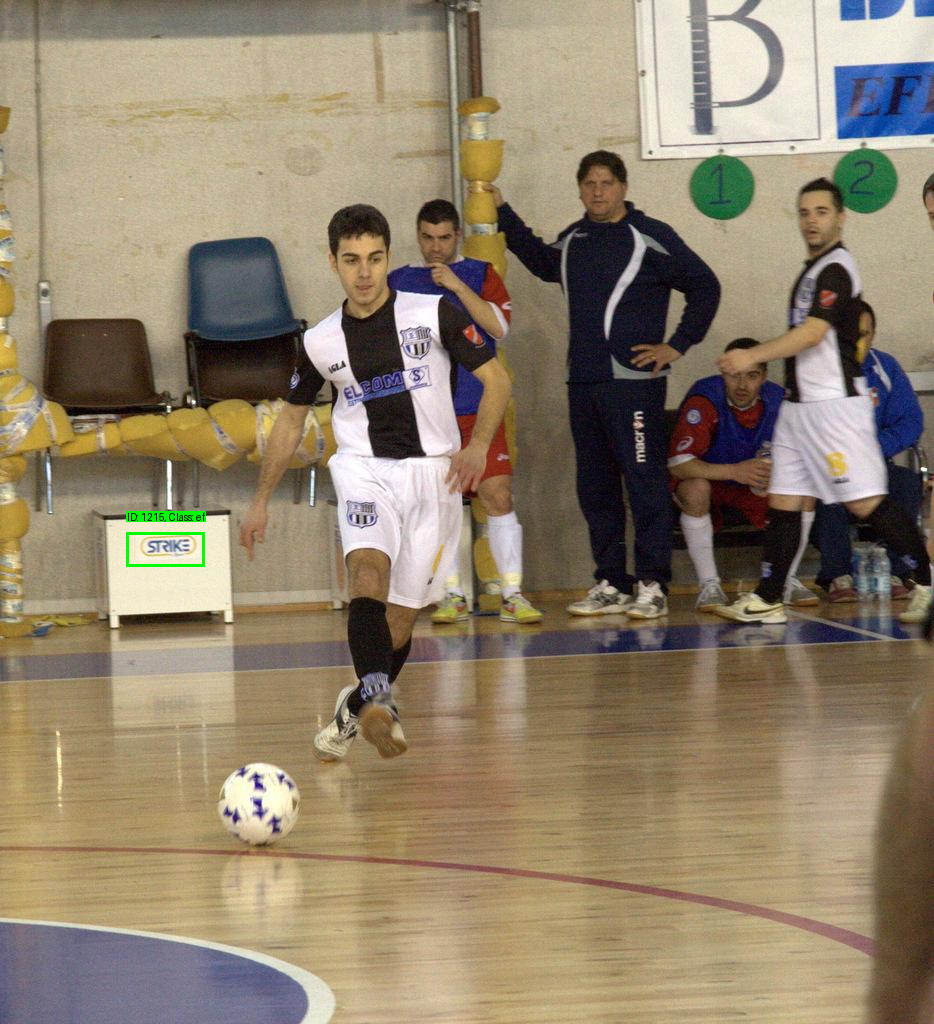

In [15]:
# =========================================================
#  数据可视化检查代码 (请在一个新的Colab单元格中运行)
# =========================================================
import cv2
import yaml
import os
import random
from PIL import Image, ImageDraw, ImageFont

# --- 使用您脚本中已定义的变量 ---
# 如果在新的会话中运行，请重新定义这些变量
BASE_DIR = "/content/drive/MyDrive/YOLOv8_Finetune_Project"
YOLO_DATA_DIR = os.path.join(BASE_DIR, "yolo_dataset")
YOLO_IMAGES_TRAIN_DIR = os.path.join(YOLO_DATA_DIR, "images", "train")
YOLO_LABELS_TRAIN_DIR = os.path.join(YOLO_DATA_DIR, "labels", "train")
YAML_FILE_PATH = os.path.join(YOLO_DATA_DIR, "dataset.yaml")

def visualize_yolo_label(image_path, label_path, class_names):
    """
    可视化单个YOLO标签。
    """
    try:
        # 使用Pillow读取图片
        image = Image.open(image_path).convert("RGB")
        img_w, img_h = image.size
        draw = ImageDraw.Draw(image)

        # 设置字体
        try:
            font = ImageFont.truetype("arial.ttf", 20)
        except IOError:
            font = ImageFont.load_default()

        if not os.path.exists(label_path):
            print(f"❌ 警告：找不到对应的标签文件: {label_path}")
            return image

        with open(label_path, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    print(f"❌ 警告：标签行格式错误: {line}")
                    continue

                class_id, x_center, y_center, norm_w, norm_h = map(float, parts)
                class_id = int(class_id)

                # 反归一化坐标
                box_w = norm_w * img_w
                box_h = norm_h * img_h
                x1 = (x_center * img_w) - (box_w / 2)
                y1 = (y_center * img_h) - (box_h / 2)
                x2 = x1 + box_w
                y2 = y1 + box_h

                # 获取类别名
                class_name = class_names.get(class_id, "未知类别")

                # 绘制边界框
                draw.rectangle([x1, y1, x2, y2], outline="lime", width=3)
                # 绘制标签文本
                label_text = f"ID: {class_id}, Class: {class_name}"
                text_bbox = draw.textbbox((x1, y1 - 22), label_text, font=font)
                draw.rectangle(text_bbox, fill="lime")
                draw.text((x1, y1 - 22), label_text, fill="black", font=font)

                print(f"✅ 成功在图上绘制: Class={class_name}, Bbox=[{x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f}]")

        return image

    except Exception as e:
        print(f"处理图片 {os.path.basename(image_path)} 时发生错误: {e}")
        return None

# --- 加载类别名称 ---
try:
    with open(YAML_FILE_PATH, 'r', encoding='utf-8') as f:
        data_yaml = yaml.safe_load(f)
    # YOLO的 'names' 是一个列表，我们转成字典 {id: name}
    class_names = {i: name for i, name in enumerate(data_yaml['names'])}
    print("✅ YAML配置文件加载成功！")
except Exception as e:
    print(f"❌ 无法加载或解析 YAML 文件: {e}")
    class_names = {}


# --- 随机选择并显示 ---
if class_names:
    image_files = os.listdir(YOLO_IMAGES_TRAIN_DIR)
    if image_files:
        # 随机选3张图片进行检查
        for _ in range(3):
            random_image_name = random.choice(image_files)
            image_path = os.path.join(YOLO_IMAGES_TRAIN_DIR, random_image_name)
            label_name = os.path.splitext(random_image_name)[0] + ".txt"
            label_path = os.path.join(YOLO_LABELS_TRAIN_DIR, label_name)

            print("\n" + "="*50)
            print(f"🔍 正在检查图片: {random_image_name}")

            # 调用可视化函数
            visualized_image = visualize_yolo_label(image_path, label_path, class_names)
            if visualized_image:
                display(visualized_image) # 在Colab/Jupyter中显示
    else:
        print("❌ 训练图片文件夹为空！")

In [17]:
# =========================================================
#  第三步：数据集特性深度诊断代码
# =========================================================
import os
import json
from collections import Counter
from tqdm import tqdm
from datasets import load_dataset, load_from_disk

# --- 复用您脚本中的配置 ---
# 请确保这些路径和您之前的脚本一致
BASE_DIR = "/content/drive/MyDrive/YOLOv8_Finetune_Project"
LOCAL_DATASET_PATH = os.path.join(BASE_DIR, "hf_dataset_cache")
DATASET_NAME = "jrzhang/TextVQA_GT_bbox"
DATASET_SPLIT = "train"

# --- 重新加载数据集进行分析 ---
print("正在加载数据集进行分析...")
if os.path.exists(LOCAL_DATASET_PATH):
    dataset = load_from_disk(LOCAL_DATASET_PATH)
else:
    dataset = load_dataset(DATASET_NAME, split=DATASET_SPLIT)
print("数据集加载完毕。")


# --- 开始诊断 ---
total_samples = 0
valid_samples = 0
invalid_bbox_count = 0
invalid_answer_count = 0
class_name_list = []

for sample in tqdm(dataset, desc="正在遍历数据集进行诊断"):
    total_samples += 1

    # 检查 answer 是否有效
    has_valid_answer = sample.get('answer') and sample['answer'][0] and sample['answer'][0].strip()
    # 检查 bbox 是否有效
    has_valid_bbox = 'bbox' in sample and sample.get('bbox')

    if has_valid_answer and has_valid_bbox:
        valid_samples += 1
        class_name_list.append(sample['answer'][0].strip())
    else:
        if not has_valid_answer:
            invalid_answer_count += 1
        if not has_valid_bbox:
            invalid_bbox_count += 1

# --- 打印诊断报告 ---
print("\n" + "="*50)
print("📊 数据集诊断报告")
print("="*50)
print(f"总样本数: {total_samples}")
print(f"有效样本数 (有答案和BBox): {valid_samples}")
print(f"被过滤的样本数: {total_samples - valid_samples}")
print(f"  - 原因：答案无效或为空: {invalid_answer_count}")
print(f"  - 原因：BBox缺失: {invalid_bbox_count}")
print("-" * 50)

# --- 类别分析 ---
if class_name_list:
    class_counts = Counter(class_name_list)
    num_unique_classes = len(class_counts)

    print(f"🔥 发现独特类别总数: {num_unique_classes}")
    print("-" * 50)

    print("📈 出现频率最高的 15 个类别:")
    for i, (name, count) in enumerate(class_counts.most_common(15)):
        print(f"  {i+1}. '{name}': {count} 次")
    print("-" * 50)

    print("📉 出现频率最低的 15 个类别:")
    # reversed() is needed to get the least common
    for i, (name, count) in enumerate(reversed(class_counts.most_common()[-15:])):
        print(f"  {i+1}. '{name}': {count} 次")
    print("-" * 50)

    # 统计只出现一次的类别数量
    once_classes = sum(1 for count in class_counts.values() if count == 1)
    print(f"⚠️ 警告：有 {once_classes} 个类别在数据集中只出现了一次！")
    print("="*50)

else:
    print("❌ 未找到任何有效的类别数据进行分析。")

正在加载数据集进行分析...
数据集加载完毕。


正在遍历数据集进行诊断: 100%|██████████| 4370/4370 [00:44<00:00, 98.28it/s] 


📊 数据集诊断报告
总样本数: 4370
有效样本数 (有答案和BBox): 4370
被过滤的样本数: 0
  - 原因：答案无效或为空: 0
  - 原因：BBox缺失: 0
--------------------------------------------------
🔥 发现独特类别总数: 3064
--------------------------------------------------
📈 出现频率最高的 15 个类别:
  1. 'yes': 174 次
  2. 'unanswerable': 99 次
  3. 'answering does not require reading text in the image': 52 次
  4. 'stop': 30 次
  5. 'no': 29 次
  6. '3': 23 次
  7. '1': 22 次
  8. '5': 19 次
  9. '9': 17 次
  10. '2': 17 次
  11. '8': 16 次
  12. '10': 14 次
  13. 'lg': 13 次
  14. '2013': 12 次
  15. 'rolex': 11 次
--------------------------------------------------
📉 出现频率最低的 15 个类别:
  1. '11:38 et': 1 次
  2. 'power supply': 1 次
  3. 'pret a manger': 1 次
  4. 'national': 1 次
  5. 'lish bros': 1 次
  6. 'jewler': 1 次
  7. '62': 1 次
  8. 'double love': 1 次
  9. 'san': 1 次
  10. 'rubino del casale': 1 次
  11. 'tyler hanover': 1 次
  12. 'tokyo black': 1 次
  13. 'crazy': 1 次
  14. '9.90': 1 次
  15. 'no trespassing': 1 次
--------------------------------------------------
⚠️ 警告：

## 步骤 3：模型训练
数据准备就绪后，训练 YOLOv8 模型非常直接。你可以使用命令行或 Python 脚本。

### Python 脚本方式 (推荐)

这种方式通过配置类来管理参数，结构清晰，易于维护和复用。

In [8]:
from ultralytics import YOLO
from dataclasses import dataclass
import torch

@dataclass
class TrainingConfig:
    """
    用于管理 YOLOv8 训练超参数的配置类。
    """
    # --- 模型与数据 ---
    pretrained_model: str = 'yolov8n.pt'  # 使用的预训练模型，yolov8n.pt是最小最快的模型
    data_config: str = YAML_FILE_PATH      # 数据集配置文件 .yaml 的路径

    # --- 训练控制 ---
    epochs: int = 100                      # 训练的总轮次
    patience: int = 20                     # 早停策略的耐心值，即20个epoch内验证集指标不提升则停止训练
    batch_size: int = 8                   # 批处理大小，根据你的GPU显存进行调整
    img_size: int = 640                    # 输入图片的尺寸

    # --- 优化器与学习率 ---
    optimizer: str = 'AdamW'               # 优化器选择，可选 'SGD', 'Adam', 'AdamW', 'NAdam', 'RAdam', 'RMSProp'
    learning_rate0: float = 0.01           # 初始学习率 (lr0)
    learning_ratef: float = 0.01           # 最终学习率 (lrf)，最终学习率 = lr0 * lrf
    momentum: float = 0.937                # SGD优化器的动量
    weight_decay: float = 0.0005           # 优化器的权重衰减

    # --- 训练过程 ---
    warmup_epochs: float = 3.0             # 学习率预热的轮次，可以是小数
    warmup_momentum: float = 0.8           # 预热期间的初始动量

    # --- 硬件与保存 ---
    device: str = '0' if torch.cuda.is_available() else 'cpu' # 自动检测并设置设备。优先使用第一块GPU，如果没有则使用CPU
    workers: int = 4                       # 数据加载时使用的工作线程数
    project_name: str = '.'                # 结果保存的项目目录，'.' 代表当前目录
    run_name: str = 'yolo_finetune_run'    # 本次训练的运行名称，结果将保存在 project_name/run_name 目录下
    save_period: int = 10                  # 每隔多少个epoch保存一次模型检查点，-1为不启用

# 实例化配置
config = TrainingConfig()

In [9]:
from ultralytics import YOLO

# 加载一个预训练模型
model = YOLO(config.pretrained_model)

# 使用配置参数开始训练
results = model.train(
    data=config.data_config,
    epochs=config.epochs,
    patience=config.patience,
    batch=config.batch_size,
    imgsz=config.img_size,
    optimizer=config.optimizer,
    lr0=config.learning_rate0,
    lrf=config.learning_ratef,
    momentum=config.momentum,
    weight_decay=config.weight_decay,
    warmup_epochs=config.warmup_epochs,
    warmup_momentum=config.warmup_momentum,
    device=config.device,
    workers=config.workers,
    project=config.project_name,
    name=config.run_name,
    save_period=config.save_period
)

print("训练完成！")
print(f"最佳模型保存在: {os.path.join(config.run_name, 'weights', 'best.pt')}")


Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_finetune_run6, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose=12.0, pr

train: Scanning /content/drive/MyDrive/YOLOv8_Finetune_Project/yolo_dataset/labels/train... 3933 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3933/3933 [00:45<00:00, 87.05it/s] 


train: New cache created: /content/drive/MyDrive/YOLOv8_Finetune_Project/yolo_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.8±0.7 ms, read: 33.4±23.0 MB/s, size: 88.0 KB)


val: Scanning /content/drive/MyDrive/YOLOv8_Finetune_Project/yolo_dataset/labels/val... 437 images, 0 backgrounds, 0 corrupt: 100%|██████████| 437/437 [00:02<00:00, 195.26it/s]


val: New cache created: /content/drive/MyDrive/YOLOv8_Finetune_Project/yolo_dataset/labels/val.cache
Plotting labels to yolo_finetune_run6/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to yolo_finetune_run6
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      6.37G      3.063      6.471      2.508          7        640: 100%|██████████| 492/492 [02:20<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:08<00:00,  3.34it/s]

                   all        437        437          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.37G      3.637       6.72      2.819         12        640: 100%|██████████| 492/492 [02:17<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:07<00:00,  3.51it/s]

                   all        437        437          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.38G      3.538      6.642      2.824         14        640: 100%|██████████| 492/492 [02:16<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:08<00:00,  3.46it/s]

                   all        437        437          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.37G      3.493      6.444      2.722          8        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:13<00:00,  2.03it/s]

                   all        437        437          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.37G      3.466      6.473      2.664          5        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:07<00:00,  3.57it/s]

                   all        437        437          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.37G      3.398      6.486      2.616          7        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:07<00:00,  3.65it/s]

                   all        437        437          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.38G      3.369      6.455      2.581          9        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.62it/s]

                   all        437        437          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.37G      3.346      6.514      2.584         11        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.90it/s]

                   all        437        437          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.37G      3.282      6.576      2.529          5        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.74it/s]


                   all        437        437          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.37G      3.317      6.544       2.55          8        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:08<00:00,  3.49it/s]

                   all        437        437          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.38G      3.287      6.598      2.488         10        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:08<00:00,  3.50it/s]

                   all        437        437          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.37G      3.293      6.559      2.491          9        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.67it/s]

                   all        437        437          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.38G      3.172      6.479      2.406          8        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:07<00:00,  3.58it/s]

                   all        437        437          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.38G      3.148      6.458      2.409          9        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:08<00:00,  3.50it/s]

                   all        437        437          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      6.38G      3.181       6.53       2.35         11        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.98it/s]

                   all        437        437          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.37G      3.164      6.432      2.421         10        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:07<00:00,  3.57it/s]

                   all        437        437          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.38G      3.112      6.413      2.375          7        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  3.11it/s]

                   all        437        437          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.37G      3.039      6.301      2.311          7        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:08<00:00,  3.34it/s]

                   all        437        437          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.38G      3.196      6.435      2.397          8        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:07<00:00,  3.63it/s]

                   all        437        437          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      6.37G      3.087      6.387      2.331         10        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:08<00:00,  3.46it/s]

                   all        437        437   4.89e-05     0.0013   0.000261   5.92e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.38G        3.1      6.327      2.307         10        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:07<00:00,  3.60it/s]

                   all        437        437   5.93e-06     0.0013   4.04e-05   4.04e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.37G      2.982      6.198      2.239          9        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.78it/s]

                   all        437        437          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.38G      2.999      6.191      2.239         10        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:07<00:00,  3.53it/s]

                   all        437        437          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.37G      3.041      6.243      2.308         10        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:07<00:00,  3.57it/s]

                   all        437        437          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.38G      3.054      6.325      2.306          8        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:08<00:00,  3.33it/s]

                   all        437        437          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.37G      3.023      6.234      2.343         10        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:07<00:00,  3.57it/s]

                   all        437        437   4.81e-06     0.0013   2.91e-05   8.73e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.38G      2.998      6.211      2.275          9        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:07<00:00,  3.61it/s]

                   all        437        437          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.37G      3.011      6.188      2.241         11        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:07<00:00,  3.60it/s]

                   all        437        437   6.56e-06     0.0013   3.46e-05   4.45e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.38G      3.048      6.196      2.268         14        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:07<00:00,  3.59it/s]

                   all        437        437          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.37G      2.953      6.099       2.18         10        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:07<00:00,  3.60it/s]

                   all        437        437   7.28e-06     0.0013   1.34e-05   1.34e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.37G      2.983      6.104      2.216          7        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:07<00:00,  3.57it/s]

                   all        437        437   9.09e-06     0.0013   0.000186   4.79e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.37G      2.956      6.129      2.231         12        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:07<00:00,  3.56it/s]

                   all        437        437   2.04e-05     0.0013   2.81e-05   8.43e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.37G      2.969      6.115      2.215          6        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:07<00:00,  3.58it/s]

                   all        437        437   1.24e-05     0.0013   0.000186   7.23e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.37G       2.89      6.021      2.187          9        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:07<00:00,  3.53it/s]

                   all        437        437   8.25e-06     0.0013   5.55e-05   1.88e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.38G      2.852      6.019      2.157         11        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:07<00:00,  3.56it/s]

                   all        437        437   4.82e-06     0.0013   8.14e-05   9.65e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.37G      2.868      5.952      2.188         12        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:07<00:00,  3.58it/s]

                   all        437        437   2.64e-05     0.0013   6.25e-05   1.87e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.37G      2.803      5.937      2.133          7        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:07<00:00,  3.52it/s]

                   all        437        437   1.07e-05     0.0013   8.29e-05   4.11e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.37G      2.883      6.065       2.19          5        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:07<00:00,  3.59it/s]

                   all        437        437   3.28e-06     0.0013   0.000184   7.36e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.37G      2.872       5.98      2.166          7        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:08<00:00,  3.49it/s]

                   all        437        437    2.6e-06     0.0013   0.000129   7.79e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.37G      2.847      5.933      2.155          8        640: 100%|██████████| 492/492 [02:16<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:07<00:00,  3.53it/s]

                   all        437        437   6.27e-06     0.0013   7.28e-05   2.19e-05
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 20, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



40 epochs completed in 1.618 hours.
Optimizer stripped from yolo_finetune_run6/weights/last.pt, 8.8MB
Optimizer stripped from yolo_finetune_run6/weights/best.pt, 8.8MB

Validating yolo_finetune_run6/weights/best.pt...
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 4,238,816 parameters, 0 gradients, 14.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 10.68it/s]


                   all        437        437    2.6e-06     0.0013   0.000129   7.56e-05
                $23.99          1          1          0          0          0          0
                $39.99          1          1          0          0          0          0
            02/20/2012          1          1          0          0          0          0
                     1          3          3          0          0          0          0
                    10          1          1          0          0          0          0
             100 north          1          1          0          0          0          0
                  100%          1          1          0          0          0          0
                   101          1          1          0          0          0          0
                    11          1          1          0          0          0          0
                 11:11          1          1          0          0          0          0
                 11:4

### 命令行方式


In [10]:
# # 训练YOLO模型
# # 使用的模型
# yolo train \
#   model=yolov8n.pt \  # 使用预训练的YOLOv8 nano模型

#   # 数据集的YAML文件路径
#   data="{YAML_FILE_PATH}" \  # 替换为你的YAML文件路径

#   # 训练的总轮数
#   epochs=100 \  # 训练100轮

#   # 提前停止的耐心值（连续多少轮没有提升时停止训练）
#   patience=20 \  # 连续20轮没有改进时停止训练

#   # 训练时的批次大小
#   batch=16 \  # 设置批次大小为16

#   # 输入图像的尺寸
#   imgsz=640 \  # 将图像大小调整为640x640

#   # 使用的优化器
#   optimizer='AdamW' \  # 使用AdamW优化器

#   # 初始学习率
#   lr0=0.01 \  # 初始学习率设置为0.01

#   # 学习率的衰减因子
#   lrf=0.01 \  # 学习率缩放因子

#   # 训练所用的设备
#   device=0 \  # 使用第一个GPU（设备0）

#   # 项目和实验的名称
#   project='.' \  # 结果保存在当前目录
#   name='yolo_finetune_run_cli' \  # 这次训练的名称

#   # 每隔多少轮保存一次模型
#   save_period=10 \  # 每10轮保存一次模型

#   # 是否绘制训练过程中的图表
#   plots=True  # 启用训练过程中的绘图


### 可视化训练结果 (损失曲线等)

训练结束后，YOLOv8 会在运行目录（例如 yolo_finetune_run）下自动保存一个 results.csv 文件，其中包含了所有训练过程中的指标。我们可以直接读取这个文件来动态绘制图表，而无需依赖预先保存的图片。

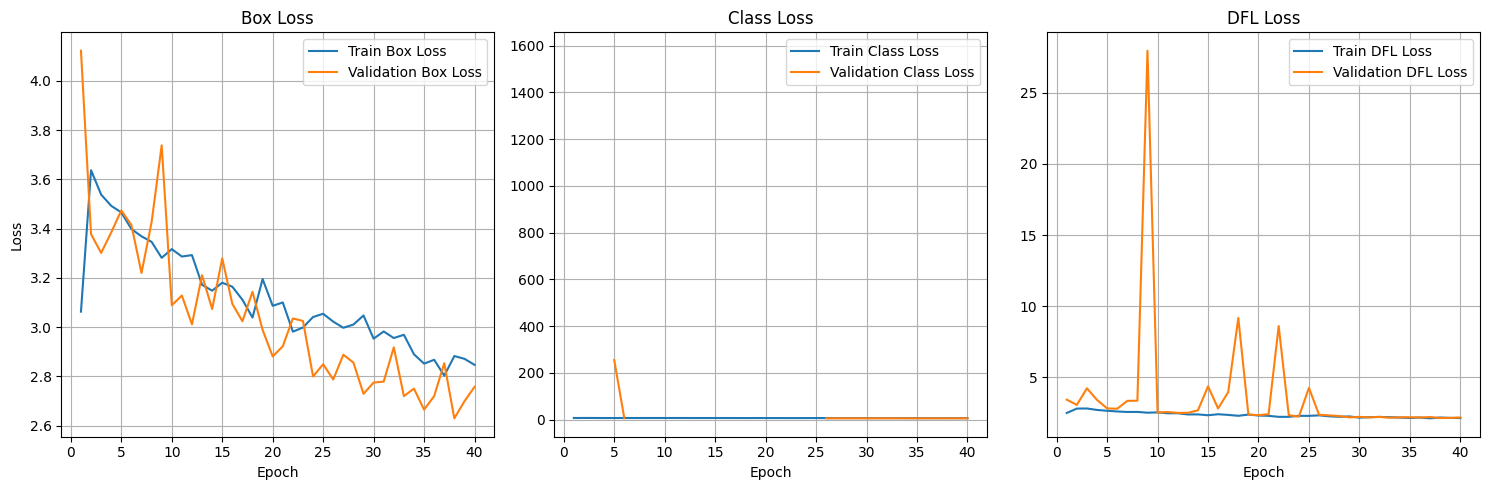

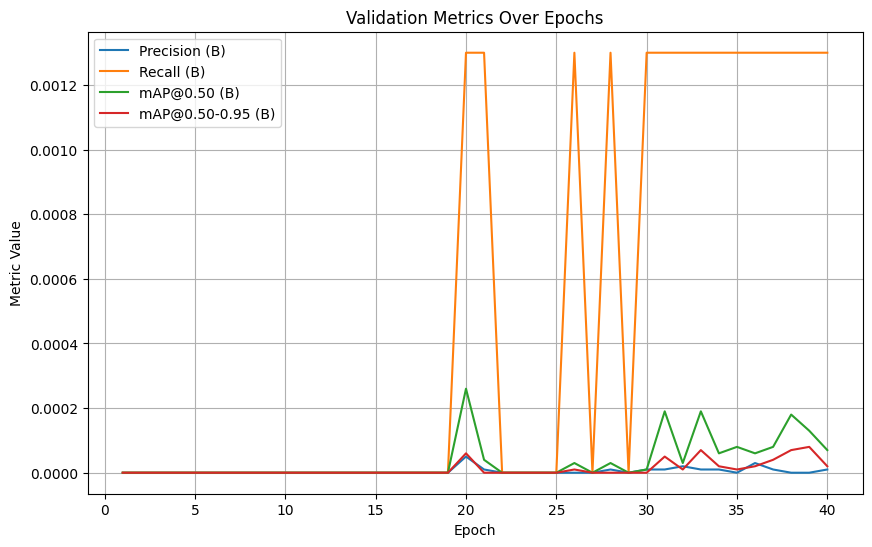

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os

print("\n--- 开始可视化训练结果 ---")

run_dir = config.run_name
results_csv_path = os.path.join(run_dir, 'results.csv')

if os.path.exists(results_csv_path):
    # 读取训练日志
    results_df = pd.read_csv(results_csv_path)
    # 清理列名（去除可能存在的前后空格）
    results_df.columns = results_df.columns.str.strip()

    # 创建一个2x2的图表网格
    fig, axs = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('训练过程可视化仪表盘 (Training Dashboard)', fontsize=20)

    # --- 图1: 损失函数 (Loss) ---
    ax1 = axs[0, 0]
    loss_cols = ['train/box_loss', 'train/cls_loss', 'train/dfl_loss']

    # 绘制训练损失
    for col in loss_cols:
        if col in results_df.columns:
            ax1.plot(results_df['epoch'], results_df[col], label=col)

    ax1.set_title('损失函数变化趋势 (Loss Curves)')
    ax1.set_xlabel('轮次 (Epoch)')
    ax1.set_ylabel('损失值 (Loss)')
    ax1.legend()
    ax1.grid(True)

    # --- 图2: mAP 指标 ---
    ax2 = axs[0, 1]
    map_cols = ['metrics/mAP50(B)', 'metrics/mAP50-95(B)']
    for col in map_cols:
        if col in results_df.columns:
            ax2.plot(results_df['epoch'], results_df[col], label=col.replace('metrics/', '').replace('(B)', ''))

    ax2.set_title('mAP 指标变化趋势 (mAP Curves)')
    ax2.set_xlabel('轮次 (Epoch)')
    ax2.set_ylabel('mAP 值')
    if ax2.has_data(): # 只有在画了线的情况下才显示图例
        ax2.legend()
    ax2.grid(True)

    # --- 图3: 精确率与召回率 (Precision & Recall) ---
    ax3 = axs[1, 0]
    pr_cols = ['metrics/precision(B)', 'metrics/recall(B)']
    for col in pr_cols:
        if col in results_df.columns:
            ax3.plot(results_df['epoch'], results_df[col], label=col.replace('metrics/', '').replace('(B)', ''))

    ax3.set_title('精确率与召回率 (Precision & Recall)')
    ax3.set_xlabel('轮次 (Epoch)')
    ax3.set_ylabel('值')
    if ax3.has_data():
        ax3.legend()
    ax3.grid(True)

    # --- 图4: 最终指标总结 ---
    ax4 = axs[1, 1]
    ax4.axis('off') # 关闭坐标轴
    try:
        # 寻找 mAP50-95 最高的轮次
        best_epoch_idx = results_df['metrics/mAP50-95(B)'].idxmax()
        best_metrics = results_df.loc[best_epoch_idx]

        summary_text = "最佳模型指标总结 (Best Metrics Summary):\n\n"
        summary_text += f"轮次 (Epoch): {int(best_metrics['epoch']) + 1}\n"
        summary_text += f"mAP@50-95: {best_metrics['metrics/mAP50-95(B)']:.4f}\n"
        summary_text += f"mAP@50: {best_metrics['metrics/mAP50(B)']:.4f}\n"
        summary_text += f"精确率 (Precision): {best_metrics['metrics/precision(B)']:.4f}\n"
        summary_text += f"召回率 (Recall): {best_metrics['metrics/recall(B)']:.4f}\n\n"
        summary_text += f"训练损失 (Box/Cls/DFL):\n"
        summary_text += f"{best_metrics['train/box_loss']:.4f} / {best_metrics['train/cls_loss']:.4f} / {best_metrics['train/dfl_loss']:.4f}\n"

        ax4.text(0.5, 0.5, summary_text, ha='center', va='center', fontsize=12, family='monospace')
    except KeyError:
        ax4.text(0.5, 0.5, '无验证指标数据可供总结。\n(No validation metrics to summarize.)',
                 ha='center', va='center', fontsize=12)
    ax4.set_title('指标总结 (Metrics Summary)')


    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 调整布局以适应主标题
    plt.show()

else:
    print(f"未找到训练日志文件: {results_csv_path}。无法绘制图表。")

## 步骤 4：推理与验证 (显示置信度)
训练完成后，我们可以使用得到的最佳模型进行推理，并修改代码以在结果图上直接显示每个检测框的置信度分数。

In [13]:
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
import os
import random

# 加载我们微调后的模型
MODEL_PATH = os.path.join("yolo_finetune_run6", "weights", "best.pt")
model = YOLO(MODEL_PATH)

# 从验证集中随机选择一张图片进行测试
image_files = os.listdir(YOLO_IMAGES_VAL_DIR)
if not image_files:
    print("验证集文件夹为空，无法进行推理。")
else:
    test_image_name = random.choice(image_files)
    test_image_path = os.path.join(YOLO_IMAGES_VAL_DIR, test_image_name)
    print(f"正在使用图片进行推理: {test_image_path}")

    # 执行推理
    results = model(test_image_path, conf=0.01)

    # --- 手动绘制结果以显示置信度 ---
    result = results[0] # 获取第一张图的推理结果
    img = Image.open(result.path).convert("RGB")
    draw = ImageDraw.Draw(img)

    # 设置字体
    try:
        font = ImageFont.truetype("arial.ttf", 20)
    except IOError:
        font = ImageFont.load_default()
    print(result.boxes)
    # 遍历每个检测到的边界框
    for box in result.boxes:
        xyxy = box.xyxy[0].cpu().numpy() # 获取坐标
        conf = box.conf[0].cpu().numpy() # 获取置信度
        cls_id = int(box.cls[0].cpu().numpy()) # 获取类别ID

        class_name = model.names[cls_id] # 从模型中获取类别名称
        label = f"{class_name}: {conf:.2f}" # 创建标签文本，包含置信度

        # 绘制边界框
        draw.rectangle(xyxy, outline="red", width=2)

        # 绘制标签背景和文本
        text_bbox = draw.textbbox((xyxy[0], xyxy[1]), label, font=font)
        draw.rectangle(text_bbox, fill="red")
        draw.text((xyxy[0], xyxy[1]), label, fill="white", font=font)

        print(xyxy, label)

    # 在 Colab 或 Jupyter 中显示图像
    print("\n--- 推理结果 (包含置信度) ---")
    # display(img)

    # # (可选) 保存结果图像
    # result_save_path = "yolo_prediction_with_confidence.jpg"
    # img.save(result_save_path)
    # print(f"预测结果已保存至: {result_save_path}")

正在使用图片进行推理: yolo_dataset/images/val/textvqa_373.jpg

image 1/1 /content/drive/MyDrive/YOLOv8_Finetune_Project/yolo_dataset/images/val/textvqa_373.jpg: 640x448 (no detections), 723.0ms
Speed: 4.6ms preprocess, 723.0ms inference, 27.2ms postprocess per image at shape (1, 3, 640, 448)
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([])
conf: tensor([])
data: tensor([], size=(0, 6))
id: None
is_track: False
orig_shape: (1024, 683)
shape: torch.Size([0, 6])
xywh: tensor([], size=(0, 4))
xywhn: tensor([], size=(0, 4))
xyxy: tensor([], size=(0, 4))
xyxyn: tensor([], size=(0, 4))

--- 推理结果 (包含置信度) ---
